# CycleGAN to transform focal series into 3D volume. 2D conv + naive structure

In [4]:
# import torch
# print(torch.cuda.get_device_properties(0))

In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()

[print(x) for x in local_device_protos if x.device_type == 'GPU']

2.8.0
name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5730467840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6449947508059093512
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419



[None]

In [1]:
from random import random
import numpy as np
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
import tensorflow.keras as k

# use instance normalization as suggested in paper
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
import matplotlib.pyplot as plt

## Discriminator. 70x70 patch GAN

In [3]:
# C64-C128-C256-C512
# After last layer, conv to 1-dimension then go through sigmoid
# axis of instancenorm is '-1', ensure features are normalized per feature map

def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_image = k.layers.Input(shape=image_shape)
    
    #C64: 4x4 kernel, strides 2x2
    d = k.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # C128: 4x4 kernel, strides 2x2
    d = k.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d) # first norm then activate
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # C256: 4x4 kernel, strides 2x2
    d = k.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # C512: 4x4 kernel, stride 2x2
    # DIY layer,not in original paper
    d = k.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    
    # second last layer. kernel 4x4, but stride 1x1
    d = k.layers.Conv2D(512, (4,4), strides=(1,1), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = k.layers.Conv2D(1, (4,4), strides=(1,1), padding='same', kernel_initializer=init)(d)
    
    # define model
    model = k.models.Model(in_image, patch_out)
    # compile the model
    # batch size is 1, Adam as opt.
    # loss of D is weighted by 50% of each update. This slows down D's change to G during training
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mse', optimizer=opt, loss_weights=[0.5]) # !!! loss_weights is plural
    return model
    

## Generator. based on resnet

In [4]:
# residual blocks contain two 3x3 Conv with same number of filters in layers

# to release the gradient vanishing and exploding
def resnet_block(n_filters, input_layer):
    # weight init
    init = RandomNormal(stddev=0.02)
    # first conv layer
    g = k.layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
#     g = k.layers.ReLU()(g)
    g = k.layers.Activation('relu')(g)  # ??? to layers.ReLU. 只有leaky直接调用，其他的用activation调用
    # second conv layer
    g = k.layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    # merge channels with input-layer
    g = k.layers.Concatenate()([g, input_layer])
    return g

In [5]:
# define G model: unet same structure

# c7s1-k: 7x7 Conv -stride 1 -Instancenorm-ReLU -k filters
# dk: 3x3 conv -stride 2 -Instancenorm-ReLU -k filters
# Rk: residual block that contains two 3x3 conv layers
# uk: 3x3 fractional~strided~conv -stride 1/2 -Instancenorm -ReLU -k filters

# two possible structures:
# with 6 res-blocks: c7s1-64, d128, d256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1-3
# with 9 res-blocks: c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128, u64,c7s1-3

def define_generator(image_shape, n_resnet=9):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = k.layers.Input(shape=image_shape)
    
    # c7s1-64
    g = k.layers.Conv2D(64, (7,7), strides=(1,1), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    # d128
    g = k.layers.Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    # d256
    g = k.layers.Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(256, g)  # !!! generate the resnet
    # u128
    g = k.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    # u64
    g = k.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = k.layers.Activation('relu')(g)
    # c7s1-3
    g = k.layers.Conv2D(3, (7,7), strides=(1,1), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = k.layers.Activation('tanh')(g)
    # define the model
    model = k.models.Model(in_image, out_image)  # generator does not compile
    return model

In [6]:
# define a composite model to update generator wuth adversarial and cycle loss
# only use to train generator
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    # use this to train both generators. But one at a time
    # trained G is tranable, others are constant
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    
    # adversarial loss
    input_gen = k.layers.Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    ouput_d = d_model(gen1_out)
    # identity loss
    input_id = k.layers.Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # cycle-loss forward
    output_f = g_model_2(gen1_out)
    # cycle-loss backward
    gen2_out = g_model_2(input_id)  # ???
    output_b = g_model_1(gen2_out)
    
    # define the model graph
    model = k.models.Model([input_gen, input_id], [ouput_d, output_id, output_f, output_b])
    
    # compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1,5,10,10], optimizer=opt) # hyper param from paper
    return model


In [7]:
# 测试输入输出的形状

image_shape = [64,64,1]
# generator A->B
g_test_AtoB = define_generator(image_shape)
# generator B->A
g_test_BtoA = define_generator(image_shape)
# D: A-> [real/ fake]
d_test_A = define_discriminator(image_shape)
# D: B-> [real/fake]
d_test_B = define_discriminator(image_shape)
# composite: A->B->[real/fake, A]
c_test_AtoB = define_composite_model(g_test_AtoB, d_test_B, g_test_BtoA, image_shape)
# composite: B->A->[real/fake, B]
c_test_BtoA = define_composite_model(g_test_BtoA, d_test_A, g_test_AtoB, image_shape)

D:\INSTALL\Anaconda\envs\EM\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


ValueError: Exception encountered when calling layer "model_3" (type Functional).

Input 0 of layer "conv2d_71" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 64, 64, 3)

Call arguments received by layer "model_3" (type Functional):
  • inputs=tf.Tensor(shape=(None, 64, 64, 3), dtype=float32)
  • training=None
  • mask=None

In [ ]:
print(c_test_AtoB.input_shape, c_test_AtoB.output_shape)
print(c_test_BtoA.input_shape, c_test_BtoA.output_shape)

## Processing images

In [7]:
# load and prepare traning images
def load_real_samples(filename):
    # load the dataset
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1-127.5)/127.5
    X2 = (X2-127.5)/127.5
    return [X1, X2]

# D needs fake and real images
# select batch of samples, return images and target.
# real images the label is '1'
def generate_real_samples(dataset, n_samples, patch_shape):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    # generate the 'real' class label
    y = np.ones((n_samples, patch_shape, patch_shape, 1)) # in th same size of one channel
    return X, y

# fake images with label '0'
def generate_fake_samples(g_model, dataset, patch_shape):
    X = g_model.predict(dataset)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

# save model
def save_models(step, g_model_AtoB, g_model_BtoA):
    # save the first generator models
    filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save(filename1)
    # save the second generator model
    filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))  

In [8]:
# predict images with save model, plot input and output images
def summarize_performance(step, g_model, trainX, name, n_samples=5):
    # sample input images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    # generate translated images
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    # scale pixels from [-1,1] to [0,1]
    X_in = (X_in + 1)/2
    X_out = (X_out + 1)/2
    # plot real images
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1+i)
        plt.axis('off')
        plt.imshow(X_in[i])
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1+i+n_samples)
        plt.axis('off')
        plt.imshow(X_out[i])
    # save plot
    filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
    plt.savefig(filename1)
    plt.close()
        

In [9]:
from random import random
test = random()

In [10]:
# update fake images pool to avoid model oscillation
# update D using a history of generated images rather than latest generators
# image buffer is 50

from random import random

def update_image_pool(pool, images, max_size=20):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif random.random() < 0.5:  # weird, must indicate the package name
            # use images, but don't add it into pool
            selected.append(image)
        else:
            # replace exiting images and use replaced 
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    out = np.asarray(selected)  # transfer into array
    return out

## Training process

In [11]:
# train cyclegan
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1):
    # training hyper param
    n_epochs, n_batch = epochs, 1 # batch_size is fixed into 1
    # output square shape of D
    n_patch = d_model_A.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # image pool for fake images
    poolA, poolB = list(), list()
    # number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # training iterations
    n_steps = bat_per_epo * n_epochs
    
    # enumerate epochs
    for i in range(n_steps):
        # for every iteration/ batch
        # sample real images from both domain
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        
        # generate fake images for both (A2B, B2A)
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        # update the fake images in the pool as buffer with 50 images
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        
        # update G-B2A via composite model
        # this is the combine model: G1 + G2 + D
        g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        # update D for A->[real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)  # since batch is 1, cannot split into half for real/fale
        
        # update G-A2B via composite model
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        
        # summarize the performance
        # batch size is 1, iteration is same as dataset
        # if there are 100 images, then 1 epoch will be 100 iterations
        print('Iterations>%d, dA[%.3f, %3.f] dB[%.3f,%.3f] g[%.3f, %.3f]'% (i+1, dA_loss1, dA_loss2, dB_loss1, dB_loss2, g_loss1, g_loss2))
        
        # evaluate performance periodically
        if (i+1) % (bat_per_epo * 1) == 0:
            # plot A->B translation
            summarize_performance(i, g_model_AtoB, trainA, 'A2B')
            # plot B->A translation
            summarize_performance(i, g_model_BtoA, trainB, 'B2A')
        
        # save model every 5 batches
        if (i+1) % (bat_per_epo * 5) == 0:
            # if batch size(total images)=100, model saved after every 75th * 5 = 375 iter 
            save_models(i, g_model_AtoB, g_model_BtoA)
            

## Load in data

In [12]:
from os import listdir
from tensorflow.keras.preprocessing.image import img_to_array, load_img  # since tf 2.9.0 it is moved to utils

In [14]:
# load into the raw data 
import os
import mrcfile
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'
import os
from random import random


def readMRC(path):
    with mrcfile.open(path, mode='r+', permissive=True) as mrc:
        mrc.header.map = mrcfile.constants.MAP_ID # for synthetic data, need to generate ID
        data = mrc.data
    return data

DATA_PATH = 'H:/My Drive/rawData/MDC_HZDR/25.02.MDC/synthetic/'
data_ids = next(os.walk(DATA_PATH))[1]
raw = []
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):  
    path = DATA_PATH + id_
    datanames = os.listdir(path)
    for dataname in datanames:
        if os.path.splitext(dataname)[1] == '.mrc': # all .mrc under the path
            temp = readMRC(path + "/" + dataname).astype(np.uint8)
            raw.append(temp)
            print(dataname)
            
focal = raw[0:3]
GT = raw[3:len(raw)]
del raw, temp, datanames, dataname, path, data_ids, n, id_

  0%|                                                                                      | 0/2 [00:00<?, ?it/s]D:\INSTALL\Anaconda\envs\EM\lib\site-packages\mrcfile\mrcinterpreter.py:219: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


tomo1_focalseries.mrc
tomo2_focalseries.mrc


 50%|███████████████████████████████████████                                       | 1/2 [00:00<00:00,  2.74it/s]

tomo3_focalseries.mrc
tomo1_groundtruth.mrc
tomo2_groundtruth.mrc


100%|██████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.75it/s]

tomo3_groundtruth.mrc


In [15]:
# raw data pre-processing: padding, reshape

import torchio as tio
from patchify import patchify, unpatchify

# training dataset raw
train_raw = np.vstack(([focal[0], focal[1]]));X_train = train_raw[...,np.newaxis].transpose((3,1,2,0)); Y_train = np.vstack(([GT[0], GT[1]]))#;label = train_label[...,np.newaxis]

trainIO = tio.ScalarImage(tensor=X_train)
target_shape = 256,256,512  # padding into the same size
crop_pad = tio.CropOrPad(target_shape, padding_mode='mean'); resized = crop_pad(trainIO) # padding with mean
X_train = resized.numpy().transpose((3,1,2,0)); X_train = X_train[...,0]
print('train img:', X_train.shape);print('train mask:', Y_train.shape)

# testing dataset raw
X_test = focal[2]; X_test = X_test[...,np.newaxis].transpose((3,1,2,0))
Y_test= GT[2]

testIO = tio.ScalarImage(tensor=X_test)
target_shape = 256,256,256
crop_pad = tio.CropOrPad(target_shape, padding_mode='mean'); resized = crop_pad(testIO)
test_padd = resized.numpy().transpose((3,1,2,0)); test_padd = test_padd[...,0];
X_test = test_padd

testStackSize = test_padd.shape  # document the original size of image stack
print('test img:', X_test.shape);print('test mask:', Y_test.shape)

train img: (512, 256, 256)
train mask: (512, 256, 256)
test img: (256, 256, 256)
test mask: (256, 256, 256)


In [15]:
# image pre-processing

data = [X_train, Y_train]  # single channel

# scale into [-1, 1]
def preprocess_data(data):
    # unpack arrays
    X1, X2 =  np.stack((data[0],)*3, axis=-1), np.stack((data[1],)*3, axis=-1)  # padding into 3 channels
    X1 = (X1 - 127.5)/ 127.5
    X2 = (X2 - 127.5)/ 127.5
    return [X1, X2]

dataset = preprocess_data(data)

print('processed: ', dataset[0].shape, dataset[1].shape)

processed:  (512, 256, 256, 3) (512, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


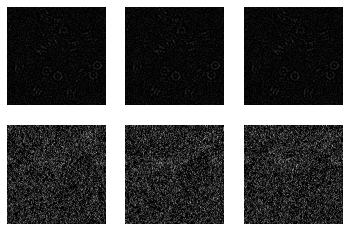

In [16]:
# sanity check
n_samples = 3

for i in range(n_samples):
    plt.subplot(2, n_samples, i+1)
    plt.axis('off')
    plt.imshow(dataset[0][i])
    
for i in range(n_samples):
    plt.subplot(2, n_samples, i+1+n_samples)
    plt.axis('off')
    plt.imshow(dataset[1][i])
plt.show()

In [17]:
image_shape = dataset[0].shape[1:]

In [18]:
# define hyper param and intance of model in cycleGAN
image_shape = dataset[0].shape[1:]
# generator A->B
g_model_AtoB = define_generator(image_shape)
# generator B->A
g_model_BtoA = define_generator(image_shape)
# D: A-> [real/ fake]
d_model_A = define_discriminator(image_shape)
# D: B-> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A->B->[real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B->A->[real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)


E:\INSTALL\anaconda\envs\seg\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Training process

In [19]:
# training

from datetime import datetime
start1 = datetime.now()
# train model
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1)

stop1 = datetime.now()

Iterations>1, dA[1.096,   1] dB[1.417,0.726] g[26.620, 26.062]
Iterations>2, dA[0.645,   1] dB[0.850,0.882] g[25.541, 25.202]
Iterations>3, dA[0.826,   1] dB[0.719,0.677] g[21.581, 19.817]
Iterations>4, dA[1.719,   1] dB[0.732,16.247] g[49.009, 19.558]
Iterations>5, dA[1.089,   1] dB[0.698,3.533] g[24.300, 19.788]
Iterations>6, dA[0.612,   1] dB[0.570,1.612] g[21.903, 19.488]
Iterations>7, dA[0.917,   1] dB[0.679,0.479] g[24.601, 25.073]
Iterations>8, dA[0.635,   1] dB[0.610,0.471] g[24.574, 24.621]
Iterations>9, dA[0.687,   1] dB[0.447,0.538] g[24.429, 24.458]
Iterations>10, dA[1.145,   1] dB[0.496,2.359] g[24.193, 19.058]
Iterations>11, dA[1.621,   0] dB[0.523,2.320] g[21.904, 19.178]
Iterations>12, dA[0.863,   1] dB[0.489,0.501] g[24.348, 24.615]
Iterations>13, dA[1.385,   1] dB[0.443,1.114] g[20.941, 18.686]
Iterations>14, dA[0.669,   1] dB[0.488,0.450] g[24.264, 24.302]
Iterations>15, dA[0.661,   1] dB[0.421,0.455] g[24.149, 24.377]
Iterations>16, dA[1.744,   0] dB[0.422,2.176] g[

In [ ]:
# execustion time
execution_time = stop1 - start1
print('Executed time: ', execution_time)

## Test

### load trained model

In [19]:
# use the saved cycleGAN for image translation
from keras.models import load_model

In [20]:
# select random samples from dataset
def select_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    return X

In [21]:
# plot the image, translation and reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
    images = np.vstack((imagesX, imagesY1, imagesY2))
    titles = ['Real', 'Generated', 'Reconstructed']
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    # plot the images
    for i in range(len(images)):
        plt.subplot(1, len(images), 1+i)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(titles[i])
    plt.show()
    

In [22]:
# loading the test dataset
A_data = X_test  # focal
B_data = Y_test  # volume

predict_data = [A_data, B_data]

predict_data = preprocess_data(predict_data)  # re-scale and pre-processing
print('focal dataset: ', predict_data[0].shape)
print('volume dataset: ', predict_data[1].shape)

focal dataset:  (256, 256, 256, 3)
volume dataset:  (256, 256, 256, 3)


In [23]:
# # load dataset
# A_data = resample(dataA_all, replace=False, n_samples=50, random_state=42)
# B_data = resample(dataB_all, replace=False, n_samples=50, random_state=42)

# A_data = (A_data - 127.5) / 127.5
# B_data = (B_data - 127.5) / 127.5

In [27]:
# load models
cust = {'InstanceNormalization': InstanceNormalization}  # !!! the lcoal normalization 
model_AtoB = load_model('./cycleGAN/model/g_model_AtoB_028160.h5', cust)
model_BtoA1 = load_model('./cycleGAN/model/g_model_BtoA_028160.h5', cust)
model_BtoA2 = load_model('./cycleGAN/model/g_model_BtoA_025600.h5', cust)

In [25]:
# prediction of the results
B_generated  = model_AtoB.predict(predict_data[0])  # transfer focal > volume
A_generated1  = model_BtoA1.predict(predict_data[1])  # volume > focal
A_generated2  = model_BtoA2.predict(predict_data[1])  # volume > focal

In [26]:
# check the generated volume and original volume

import napari

viewer1 = napari.view_image(B_generated)  # generated volume
napari.run() 
viewer2 = napari.view_image(predict_data[1])  
napari.run() 


In [28]:
# check the generated focal and original focal

import napari

viewer1 = napari.view_image(A_generated1)  # generated focal-28160 model
napari.run() 
viewer2 = napari.view_image(A_generated2)  # generated focal-25600 model
napari.run() 
viewer3 = napari.view_image(predict_data[0])  
napari.run() 